<a href="https://colab.research.google.com/github/miguel-fc/Neutron_Reflect/blob/main/nr_v12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/miguel-fc/Neutron_Reflect.git

Cloning into 'Neutron_Reflect'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 111 (delta 1), reused 4 (delta 1), pack-reused 106
Receiving objects: 100% (111/111), 5.47 MiB | 12.25 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [ ]:
# Import Python related required packages
import io
import os
import cv2
import gdown
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import plotly.express as px
from sklearn.metrics import mean_squared_error
from scipy.stats import gaussian_kde, norm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
import pandas as pd
from tqdm import tqdm
import pickle

#Import torch related packages
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split, Dataset, TensorDataset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
#Set these important parameters
#Dimension of the latent space 
d = 3
#Dimension of the graphs
in_d1 = 2
in_d2 = 96
#Number of epochs
num_epochs = 120
#Number of layers
num_layers = 1
#Number of neurons
num_neur=150 


In [ ]:
cd Neutron_Reflect/

/content/Neutron_Reflect/Neutron_Reflect


In [ ]:
#Stored those numpy arrays
data_path = './data/'
sld_arr = np.load(os.path.join(data_path,'sld_fp49.npy'))
params_arr = np.load(os.path.join(data_path,'params_fp49.npy'))

In [ ]:
sld_arr.shape, params_arr.shape, sld_arr.dtype, params_arr.dtype

((5942, 2, 96), (5942, 3), dtype('float64'), dtype('float64'))

In [ ]:
#Import packages from the github clone
import data_preparation as dpre
import AutoEnc as au
import MLP as mlp

In [ ]:
#Prepare data files
xtrain, ytrain, xval, yval, xtest, ytest = \
dpre.split_input_arrays(sld_arr,params_arr, size_split=0.8)

xtrain.shape, ytrain.shape, xval.shape, yval.shape, xtest.shape, ytest.shape
(4753, 2, 96) (4753, 3) (594, 2, 96) (594, 3) (595, 2, 96) (595, 3)


In [ ]:
#Prepare data files, continuation
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = \
dpre.get_dataloaders_fromsplitarrays(xtrain,ytrain,xval,yval,xtest,ytest,batch_size=50)

In [ ]:
loss_fn = torch.nn.MSELoss()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


In [ ]:
def initialize_model(d,in_d1,in_d2,num_layers,num_neur):
  lr= 0.001
  torch.manual_seed(0)
  
  encoder = au.Encoder(encoded_space_dim=d,dim1=in_d1,dim2=in_d2,num_layers=num_layers,num_neur=num_neur)
  decoder = au.Decoder(encoded_space_dim=d,dim1=in_d1,dim2=in_d2,num_layers=num_layers,num_neur=num_neur)

  params_to_optimize = [
     {'params': encoder.parameters()},
     {'params': decoder.parameters()}
  ]

  optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)


  return encoder, decoder, optim

In [ ]:
#Initialize autoencoder
encoder, decoder, optim = initialize_model(d,in_d1,in_d2,num_layers,num_neur)

#train and validate
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
  # print (epoch)
  train_loss = au.fit(encoder,decoder,device,train_loader,loss_fn,optim)
  val_loss = au.val(encoder,decoder,device,valid_loader,loss_fn)
  print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
  diz_loss['train_loss'].append(train_loss)
  diz_loss['val_loss'].append(val_loss)
  # plot_ae_outputs(model,train_dataset,device,n=10)

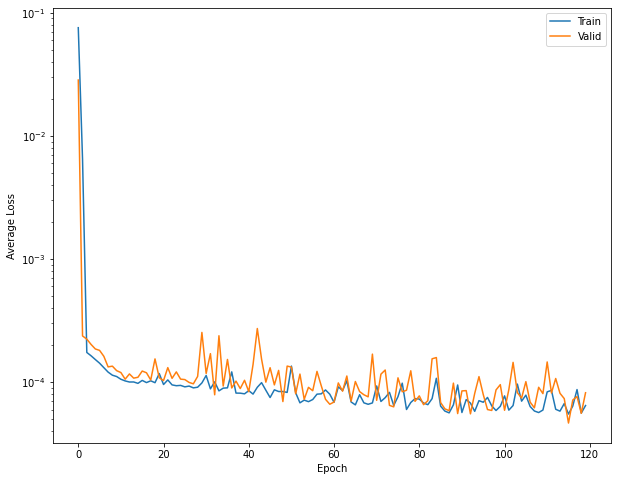

In [ ]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

For image 0, the loss = 4.083495514350943e-05
For image 1, the loss = 5.270710607874207e-05
For image 2, the loss = 0.00010666375601431355
For image 3, the loss = 0.00012907947530038655
For image 4, the loss = 4.021076165372506e-05
For image 5, the loss = 0.0002346944820601493
For image 6, the loss = 4.9107471568277106e-05
For image 7, the loss = 0.00019345333566889167
For image 8, the loss = 5.184075780562125e-05
For image 9, the loss = 9.214571764459834e-05


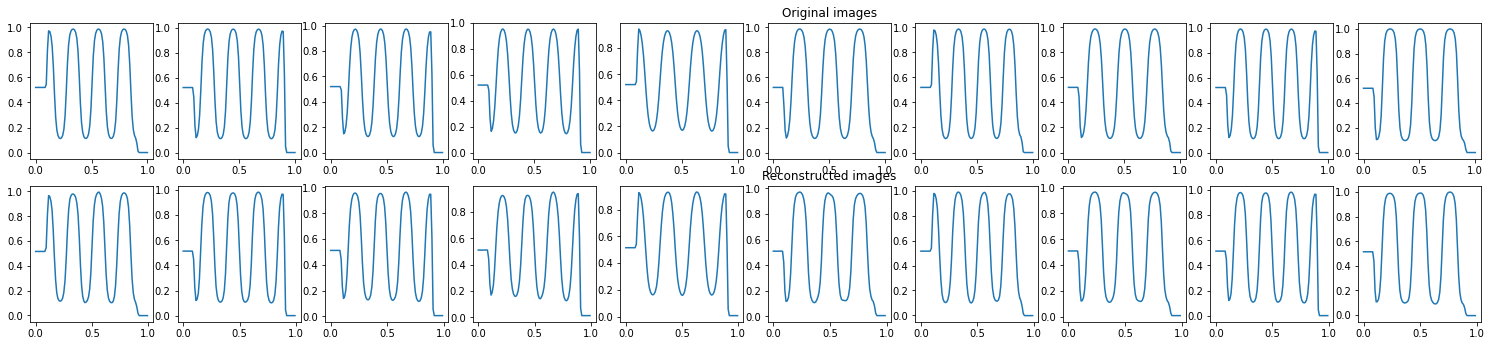

In [ ]:
au.test(encoder,decoder,test_dataset,device,loss_fn,in_d1,in_d2,n=10)

tensor([0.1108, 3.3864, 1.4483])
tensor([2.1907, 0.7971, 2.5894])


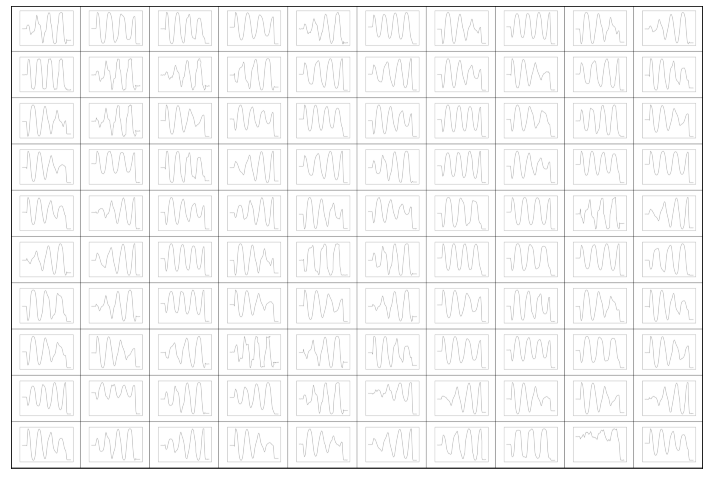

In [ ]:
#Interpolating in the latent space
#This is similar to a manifold

def get_img_from_fig(fig, dpi=180):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    plt.close()
    img = cv2.imdecode(img_arr,0)

    return img

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_xticks([])
    ax.set_yticks([])

encoder.eval()
decoder.eval()

with torch.no_grad():
    images, labels = iter(train_loader).next()
    images = images.view(images.size(0), -1).to(device) 

    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)


    latent = torch.randn(200, d)*std + mean
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.view(img_recon.size(0), in_d1,in_d2).cpu()


n_img = []
for i in range(img_recon.shape[0]):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.close()
    ax.plot(img_recon[i][0],img_recon[i][1])
    n_img.append(get_img_from_fig(fig))

n_img = torch.from_numpy(np.asarray(n_img))
n_img = n_img[:,np.newaxis,:,:]

fig, ax = plt.subplots(figsize=(20, 8.5))
show_image(torchvision.utils.make_grid(n_img[:100],10,5))
plt.show()

In [ ]:
nlabel = params_arr.shape[1]
# nlabel

for i in range(nlabel):
  label_index = 'label'+str(i)
  print(label_index)

label0
label1
label2


In [ ]:
encoded_samples = []
for sample in train_dataset:
    img = sample[0].unsqueeze(0)
    img = img.view(img.size(0), -1).to(device) 
    label_val = sample[1]
    # print(label_val.shape)
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    encoded_img = encoded_img.flatten().cpu().numpy()
    # print(enumerate(encoded_img))
    encoded_sample = {f"l{i+1}": enc for i, enc in enumerate(encoded_img)}
    for i in range(nlabel):
      label_index = 'label'+str(i)
      encoded_sample[label_index] = label_val[i].numpy()
    # encoded_sample['label1'] = label[1].numpy()
    # encoded_sample['label2'] = label[2].numpy()
    # encoded_sample['label3'] = label[3].numpy()
    encoded_samples.append(encoded_sample)
df_encoded_samples = pd.DataFrame(encoded_samples)
df_encoded_samples

,l1,l2,l3,label0,label1,label2
0,-0.841872,4.212524,-1.661195,0.0919,0.591,-0.03031
1,2.165793,2.314084,4.401583,0.169,-0.0853,0.56888
2,1.876192,2.468895,4.051672,0.0643,-0.557,0.47694
3,2.095443,2.322014,4.458281,0.172,-0.293,0.25449
4,-2.907669,3.810172,3.274606,0.12,-0.183,-0.16274
...,...,...,...,...,...,...
4748,1.734380,2.457747,4.279139,0.0857,-0.584,-0.03988
4749,2.116757,2.319746,4.443316,0.141,-0.286,0.3762
4750,-0.888882,4.177400,-1.382263,0.0766,0.365,-0.27593
4751,-1.038596,4.294332,-1.856034,0.112,0.408,0.00328


In [ ]:
#Creating dataloaders for the MLP. This includes train, valid and test

img, out_img, train_latent_var, train_labels_var = au.get_latent_variables(encoder,decoder,device,train_loader)
print(img.shape, out_img.shape, train_latent_var.shape, train_labels_var.shape)

img, out_img, valid_latent_var, valid_labels_var = au.get_latent_variables(encoder,decoder,device,valid_loader)
print(img.shape, out_img.shape, valid_latent_var.shape, valid_labels_var.shape)


img, out_img, test_latent_var, test_labels_var = au.get_latent_variables(encoder,decoder,device,test_loader)
print(img.shape, out_img.shape, test_latent_var.shape, test_labels_var.shape)


mlp_train_dataset, mlp_valid_dataset, mlp_test_dataset, mlp_train_loader, mlp_valid_loader, mlp_test_loader = \
dpre.get_dataloaders_fromsplitarrays(train_latent_var.numpy(),train_labels_var.numpy(), \
                                valid_latent_var.numpy(),valid_labels_var.numpy(),\
                                test_latent_var.numpy(),test_labels_var.numpy(), \
                                batch_size=50)

torch.Size([4753, 192]) torch.Size([4753, 192]) torch.Size([4753, 3]) torch.Size([4753, 3])
torch.Size([594, 192]) torch.Size([594, 192]) torch.Size([594, 3]) torch.Size([594, 3])
torch.Size([595, 192]) torch.Size([595, 192]) torch.Size([595, 3]) torch.Size([595, 3])


In [ ]:
# #Saving encoder and decoder 
# torch.save(encoder.state_dict(),"./encoder.pt")
# torch.save(decoder.state_dict(),"./decoder.pt")

In [ ]:
# #Reloading the encoder and decoderen
# encoder.load_state_dict(torch.load("./encoder.pt"))
# decoder.load_state_dict(torch.load("./decoder.pt"))

In [ ]:
num_epochs = 1600
num_layers = 1
num_neur = 500

def initialize_mlp(dim,nlabel,num_layers,num_neur):
  lr= 0.001
  torch.manual_seed(0)
  
  model = mlp.MLP(dim=d,nlabel=nlabel,num_layers=num_layers,num_neur=num_neur)

  params_to_optimize = [
     {'params': model.parameters()},
  ]

  optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)


  return model, optim

In [ ]:
# #Running the MLP
# ### Define the loss function 
# loss_fn = torch.nn.MSELoss()

# ### Define the learning rate
# lr= 0.001

# ### Set the random seed for reproducible results
# torch.manual_seed(0)

# #model 
# model = mlp.MLP(dim=d,nlabel=nlabel)
# params_to_optimize = [
#     {'params': model.parameters()}
# ]

# #Define the optimizer
# optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# #Checking the device
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# print(f'Selected device: {device}')

In [ ]:
#Initialize mlp
model, optim = initialize_mlp(d,nlabel,num_layers,num_neur)
model.to(device)

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=3, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=500, out_features=3, bias=True)
  )
)

In [ ]:
#Initialize mlp
model, optim = initialize_mlp(d,nlabel,num_layers,num_neur)

#Train and validate
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
  # print (epoch)
  train_loss = mlp.fit(model,device,mlp_train_loader,loss_fn,optim)
  val_loss = mlp.val(model,device,mlp_valid_loader,loss_fn)
  print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
  diz_loss['train_loss'].append(train_loss)
  diz_loss['val_loss'].append(val_loss)

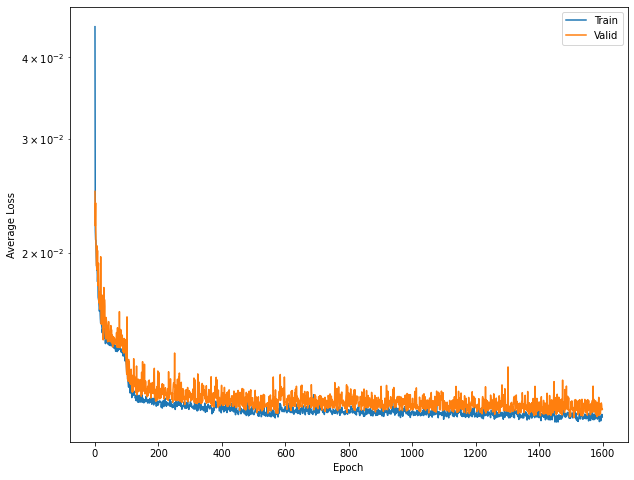

In [ ]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [ ]:
out_samples = []
for sample in mlp_test_dataset:
    img = sample[0]
    img = img.to(device) 
    label_val = sample[1]
    # print(label_val.shape)
    model.eval()
    with torch.no_grad():
        out_label  = model(img)
    out_label = out_label.cpu().numpy()
    # print(enumerate(encoded_img))
    out_sample = {f"pred_label{i}": enc for i, enc in enumerate(out_label)}
    for i in range(nlabel):
      label_index = 'label'+str(i)
      out_sample[label_index] = label_val[i].numpy()
    out_samples.append(out_sample)
df_out_samples = pd.DataFrame(out_samples)
df_out_samples

,pred_label0,pred_label1,pred_label2,label0,label1,label2
0,0.148624,-0.268498,0.522295,0.152,-0.561,0.48481
1,0.153741,0.041434,0.565919,0.132,0.0311,0.57967
2,0.149925,0.445918,-0.323115,0.153,0.536,-0.38828
3,0.151803,0.274527,0.336796,0.126,0.235,0.28883
4,0.065015,0.466885,-0.093054,0.0593,0.455,-0.06932
...,...,...,...,...,...,...
590,0.063199,0.147001,-0.410812,0.062,0.175,-0.42259
591,0.152408,0.290517,0.321019,0.191,0.522,0.56365
592,0.153570,0.041728,0.564639,0.158,0.0263,0.48864
593,0.144987,0.063664,-0.354715,0.126,0.117,-0.32443


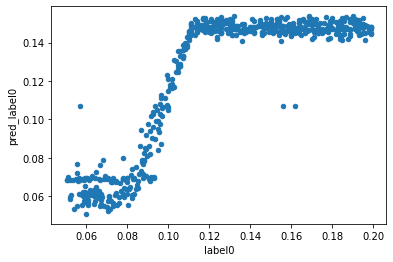

In [ ]:
df_out_samples.plot(x ='label0', y='pred_label0', kind = 'scatter')
plt.show()

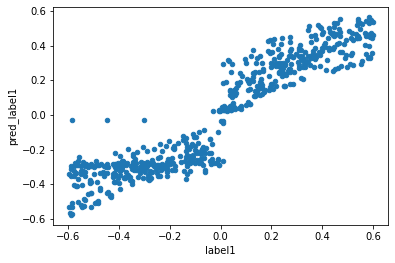

In [ ]:
df_out_samples.plot(x ='label1', y='pred_label1', kind = 'scatter')
plt.show()

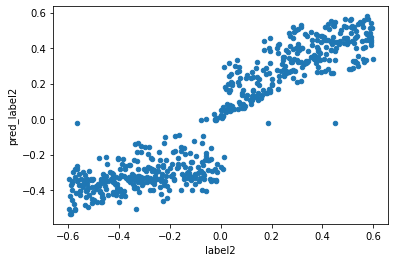

In [ ]:
df_out_samples.plot(x ='label2', y='pred_label2', kind = 'scatter')
plt.show()

In [ ]:
#Saving data into GitHub

# torch.save(train_latent_var,os.path.join(data_path,'train_latent_var.pt'))
# torch.save(train_latent_var,'train_labels_var.pt')

# torch.save(valid_latent_var,'valid_latent_var.pt')
# torch.save(valid_latent_var,'valid_labels_var.pt')

# torch.save(test_latent_var,'test_latent_var.pt')
# torch.save(test_latent_var,'test_labels_var.pt')


# torch.save(mlp_train_loader,'mlp_train_loader.pth')
# torch.save(mlp_valid_loader,'mlp_valid_loader.pth')
# torch.save(mlp_test_loader,'mlp_test_loader.pth')

# !mv mlp_train_loader.pth /content/drive/MyDrive/neutron_reflectivity/
# !mv mlp_valid_loader.pth /content/drive/MyDrive/neutron_reflectivity/
# !mv mlp_test_loader.pth /content/drive/MyDrive/neutron_reflectivity/

# torch.save(mlp_test_dataset,'mlp_test_dataset.pth')
# !mv mlp_test_dataset.pth /content/drive/MyDrive/neutron_reflectivity/

# #Saving also the pandas dataframe for the encoded sample

# #Having issues with the way a saved .csv and loaded one look like. 
# # df_encoded_samples.to_csv('encoded.csv', sep ='\t')
# # !mv encoded.csv /content/drive/MyDrive/neutron_reflectivity/

# #Using pickle instead.
# df_encoded_samples.to_pickle('df_encoded_samples.pkl')
# !mv df_encoded_samples.pkl /content/drive/MyDrive/neutron_reflectivity/

In [ ]:
#Testing the model in experimental data
#Stored those numpy arrays
data_path = './exptdata/'

#Functions to read the sld and the param files
def read_sld_files(file_name):
    print(file_name)
    with open(file_name, 'r') as data:
        x = []
        y = []
        xy = [x,y]
        for line in data:
            p = line.split()
            # print(p)
            x.append(float(p[0]))
            y.append(float(p[1]))
            xy = x,y
            # array_xy = np.asarray(xy)

    return np.asarray(x),np.asarray(y)


folder = data_path


datafiles = [os.path.join(root, filename)
          for root, dirs, files in os.walk(folder)
          for filename in files
          if filename.lower().startswith('sld')]

for file in datafiles:
  dataindiv = read_sld_files(file)

dataindiv
# sld_arr = np.load(os.path.join(data_path,'sld_fp49.npy'))
# params_arr = np.load(os.path.join(data_path,'params_fp49.npy'))

./exptdata/sld_data.txt


(array([   0.    ,   19.7887,   39.5773,   59.366 ,   79.1546,   98.9433,
         118.732 ,  138.521 ,  158.309 ,  178.098 ,  197.887 ,  217.675 ,
         237.464 ,  257.253 ,  277.041 ,  296.83  ,  316.619 ,  336.407 ,
         356.196 ,  375.984 ,  395.773 ,  415.562 ,  435.35  ,  455.139 ,
         474.928 ,  494.716 ,  514.505 ,  534.294 ,  554.082 ,  573.871 ,
         593.66  ,  613.448 ,  633.237 ,  653.026 ,  672.814 ,  692.603 ,
         712.392 ,  732.18  ,  751.969 ,  771.758 ,  791.546 ,  811.335 ,
         831.124 ,  850.912 ,  870.701 ,  890.49  ,  910.278 ,  930.067 ,
         949.856 ,  969.644 ,  989.433 , 1009.22  , 1029.01  , 1048.8   ,
        1068.59  , 1088.38  , 1108.16  , 1127.95  , 1147.74  , 1167.53  ,
        1187.32  , 1207.11  , 1226.9   , 1246.69  , 1266.47  , 1286.26  ,
        1306.05  , 1325.84  , 1345.63  , 1365.42  , 1385.21  , 1404.99  ,
        1424.78  , 1444.57  , 1464.36  , 1484.15  , 1503.94  , 1523.73  ,
        1543.52  , 1563.3   , 1583.09 

In [ ]:
dataindv_arr = np.asarray(dataindiv)
# dataindv_arr.shape

sld = []
sld.append(dataindv_arr)
sld_arr = np.asarray(sld)
sld_arr.shape

(1, 2, 96)

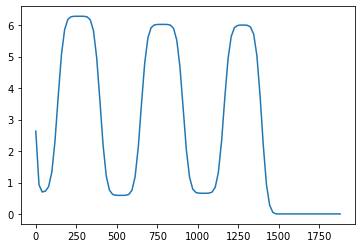

In [ ]:
plt.plot(sld_arr[0][0],sld_arr[0][1])

In [ ]:
#Normalizing the sld curves by min/max

#First finding the min/max
x_val=sld_arr[:,0,:]
x_min = x_val.min()
x_max = x_val.max()
print('x-range = ', x_min, ' to ',x_max)
y_val=sld_arr[:,1,:]
y_min = y_val.min()
y_max = y_val.max()
print('y-range = ', y_min, ' to ',y_max)

x-range =  0.0  to  1879.92
y-range =  0.00808414  to  6.2808628569


In [ ]:
#Normalize
sld_arr[:,0,:] = (sld_arr[:,0,:] - x_min)/(x_max - x_min)
sld_arr[:,1,:] = (sld_arr[:,1,:] - y_min)/(y_max - y_min)

In [ ]:
sld_arr.min(), sld_arr.max()

(0.0, 1.0)

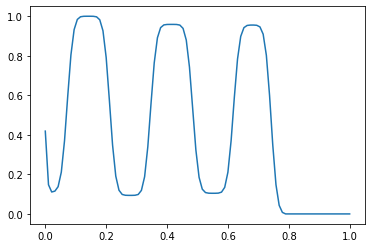

In [ ]:
plt.plot(sld_arr[0][0],sld_arr[0][1])

In [ ]:
encoder.eval().to(device)

Encoder(
  (encoder): Sequential(
    (0): Linear(in_features=192, out_features=150, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=150, out_features=150, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=150, out_features=3, bias=True)
  )
)

In [ ]:
decoder.eval().to(device)

Decoder(
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=150, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=150, out_features=150, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=150, out_features=192, bias=True)
  )
)

In [ ]:
img = torch.from_numpy(sld_arr).float()
img = img.view(img.size(0), -1).to(device)

In [ ]:
with torch.no_grad(): 
  latent = encoder(img)
  decoded_img = decoder(latent)


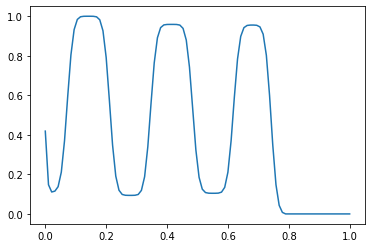

In [ ]:
plt.plot(img.cpu().reshape(in_d1,in_d2).numpy()[0],img.cpu().reshape(in_d1,in_d2).numpy()[1]) 

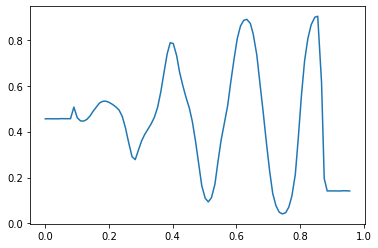

In [ ]:
plt.plot(decoded_img.cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img.cpu().reshape(in_d1,in_d2).numpy()[1]) 
